In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler , RobustScaler , MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
from datasist.structdata import detect_outliers
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
sns.set(rc={'figure.figsize':(10, 10)})

In [96]:
# !pip install datasist

In [3]:
df_flights = pd.read_csv('../input/flight-delays/flights.csv')
df_flights.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [6]:
df_flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

In [7]:
columns = ['YEAR', 'MONTH', 'DAY', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT','DISTANCE','ARRIVAL_DELAY','CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY']

In [8]:
df_flights = df_flights[columns].sample(50000).copy()
df_flights.head()

,YEAR,MONTH,DAY,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,ARRIVAL_DELAY,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY
2501019,2015,6,7,MQ,3392,N819MQ,DFW,CLL,164,5.0,0,NaN,NaN,NaN,NaN
3792488,2015,8,24,UA,1418,N34455,SAN,IAH,1303,-6.0,0,NaN,NaN,NaN,NaN
2747636,2015,6,22,WN,3686,N8650F,DAL,LAX,1246,-12.0,0,NaN,NaN,NaN,NaN
2801139,2015,6,25,US,2036,N730US,CLT,SYR,603,-8.0,0,NaN,NaN,NaN,NaN
1813704,2015,4,26,EV,4663,N13202,OKC,IAH,395,-11.0,0,NaN,NaN,NaN,NaN


In [9]:
df_flights.reset_index(inplace = True)
df_flights.head()

,index,YEAR,MONTH,DAY,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,ARRIVAL_DELAY,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY
0,2501019,2015,6,7,MQ,3392,N819MQ,DFW,CLL,164,5.0,0,NaN,NaN,NaN,NaN
1,3792488,2015,8,24,UA,1418,N34455,SAN,IAH,1303,-6.0,0,NaN,NaN,NaN,NaN
2,2747636,2015,6,22,WN,3686,N8650F,DAL,LAX,1246,-12.0,0,NaN,NaN,NaN,NaN
3,2801139,2015,6,25,US,2036,N730US,CLT,SYR,603,-8.0,0,NaN,NaN,NaN,NaN
4,1813704,2015,4,26,EV,4663,N13202,OKC,IAH,395,-11.0,0,NaN,NaN,NaN,NaN


In [10]:
df_flights.drop('index',axis = 1,inplace = True )

In [11]:
df_flights.head()

,YEAR,MONTH,DAY,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DISTANCE,ARRIVAL_DELAY,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY
0,2015,6,7,MQ,3392,N819MQ,DFW,CLL,164,5.0,0,NaN,NaN,NaN,NaN
1,2015,8,24,UA,1418,N34455,SAN,IAH,1303,-6.0,0,NaN,NaN,NaN,NaN
2,2015,6,22,WN,3686,N8650F,DAL,LAX,1246,-12.0,0,NaN,NaN,NaN,NaN
3,2015,6,25,US,2036,N730US,CLT,SYR,603,-8.0,0,NaN,NaN,NaN,NaN
4,2015,4,26,EV,4663,N13202,OKC,IAH,395,-11.0,0,NaN,NaN,NaN,NaN


In [12]:
df_flights.shape

(50000, 15)

In [13]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YEAR                 50000 non-null  int64  
 1   MONTH                50000 non-null  int64  
 2   DAY                  50000 non-null  int64  
 3   AIRLINE              50000 non-null  object 
 4   FLIGHT_NUMBER        50000 non-null  int64  
 5   TAIL_NUMBER          49890 non-null  object 
 6   ORIGIN_AIRPORT       50000 non-null  object 
 7   DESTINATION_AIRPORT  50000 non-null  object 
 8   DISTANCE             50000 non-null  int64  
 9   ARRIVAL_DELAY        49148 non-null  float64
 10  CANCELLED            50000 non-null  int64  
 11  CANCELLATION_REASON  751 non-null    object 
 12  AIR_SYSTEM_DELAY     9232 non-null   float64
 13  SECURITY_DELAY       9232 non-null   float64
 14  AIRLINE_DELAY        9232 non-null   float64
dtypes: float64(4), int64(6), object(5)
m

In [14]:
df_flights.duplicated().sum()

0

In [15]:
df_flights.isna().sum()/ df_flights.shape[0] *100

YEAR                    0.000
MONTH                   0.000
DAY                     0.000
AIRLINE                 0.000
FLIGHT_NUMBER           0.000
TAIL_NUMBER             0.220
ORIGIN_AIRPORT          0.000
DESTINATION_AIRPORT     0.000
DISTANCE                0.000
ARRIVAL_DELAY           1.704
CANCELLED               0.000
CANCELLATION_REASON    98.498
AIR_SYSTEM_DELAY       81.536
SECURITY_DELAY         81.536
AIRLINE_DELAY          81.536
dtype: float64

In [16]:
df_flights.YEAR.value_counts()

2015    50000
Name: YEAR, dtype: int64

In [17]:
df_flights.MONTH.value_counts()

7     4502
8     4363
3     4345
6     4309
10    4290
4     4189
12    4155
5     4135
1     4095
11    4014
9     4008
2     3595
Name: MONTH, dtype: int64

In [18]:
df_flights.DAY.value_counts()

4     1708
27    1705
9     1703
5     1699
3     1695
23    1694
13    1685
10    1680
2     1679
22    1674
12    1665
16    1662
15    1651
8     1650
11    1640
14    1638
1     1630
21    1628
20    1626
28    1624
7     1621
19    1606
18    1605
6     1591
24    1588
25    1584
26    1581
17    1558
30    1548
29    1499
31     883
Name: DAY, dtype: int64

In [19]:
df_flights.AIRLINE.value_counts()

WN    10655
DL     7484
AA     6269
OO     5124
EV     4920
UA     4388
MQ     2612
B6     2352
US     1780
AS     1447
NK     1006
F9      771
HA      674
VX      518
Name: AIRLINE, dtype: int64

In [20]:
df_flights.FLIGHT_NUMBER.value_counts()

469     43
1114    38
326     37
689     36
679     35
        ..
6590     1
5963     1
6395     1
3092     1
4222     1
Name: FLIGHT_NUMBER, Length: 6108, dtype: int64

In [21]:
df_flights.TAIL_NUMBER.value_counts()

N489HA    43
N492HA    40
N486HA    35
N483HA    35
N354JB    33
          ..
N180DN     1
N637AW     1
N657UA     1
N77022     1
N5EXAA     1
Name: TAIL_NUMBER, Length: 4516, dtype: int64

In [22]:
columns_to_drop = ['YEAR','TAIL_NUMBER', 'FLIGHT_NUMBER']
df_flights.drop(columns_to_drop, axis = 1, inplace = True)

### Univariate analysis

In [23]:
df_flights.columns

Index(['MONTH', 'DAY', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DISTANCE', 'ARRIVAL_DELAY', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY'],
      dtype='object')

<AxesSubplot:xlabel='MONTH', ylabel='count'>

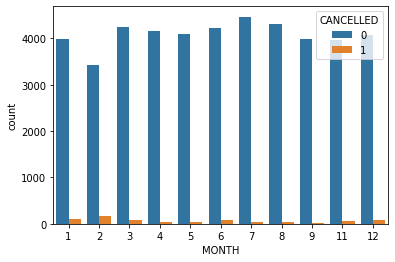

In [65]:
sns.countplot(data = df_flights, x = 'MONTH', hue = 'CANCELLED')

<AxesSubplot:xlabel='DAY', ylabel='count'>

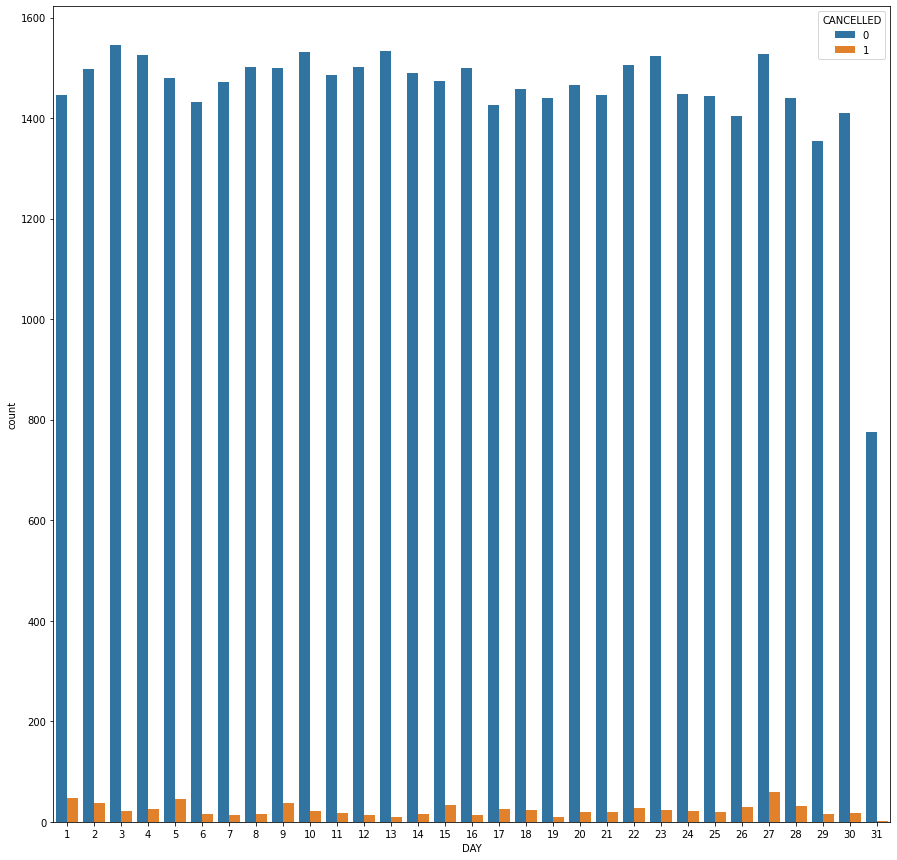

In [68]:
plt.figure(figsize = (15, 15))
sns.countplot(data = df_flights, x = 'DAY', hue = 'CANCELLED')

<AxesSubplot:xlabel='AIRLINE', ylabel='count'>

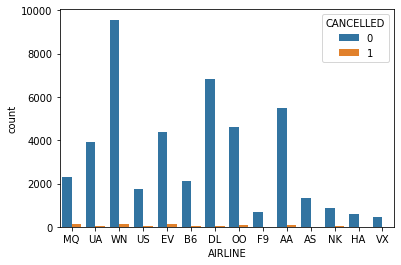

In [69]:
sns.countplot(data = df_flights, x = 'AIRLINE', hue = 'CANCELLED')

In [27]:
df_flights.columns

Index(['MONTH', 'DAY', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DISTANCE', 'ARRIVAL_DELAY', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY'],
      dtype='object')

In [28]:
df_airports = pd.read_csv('../input/flight-delays/airports.csv')
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [31]:
codes = list(df_airports.IATA_CODE.unique())
codes[:10]

['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK']

In [44]:
indices_to_remove = []
for r in df_flights.iterrows():
    if r[1].ORIGIN_AIRPORT not in codes:
        indices_to_remove.append(r[0])

In [45]:
len(indices_to_remove)

4290

In [46]:
df_flights.drop(indices_to_remove, axis = 0, inplace = True)

In [47]:
df_flights.columns

Index(['MONTH', 'DAY', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DISTANCE', 'ARRIVAL_DELAY', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY'],
      dtype='object')

In [49]:
df_flights.ORIGIN_AIRPORT.value_counts()

ATL    2895
ORD    2475
DFW    2080
DEN    1683
LAX    1666
       ... 
HYS       2
CEC       2
AKN       2
WYS       1
ESC       1
Name: ORIGIN_AIRPORT, Length: 316, dtype: int64

<AxesSubplot:xlabel='ORIGIN_AIRPORT', ylabel='count'>

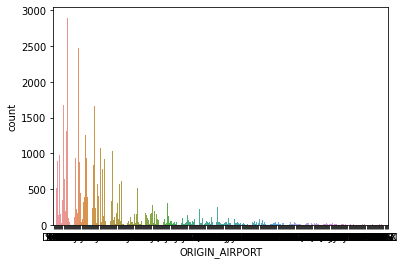

In [50]:
sns.countplot(data = df_flights, x = 'ORIGIN_AIRPORT')

<AxesSubplot:>

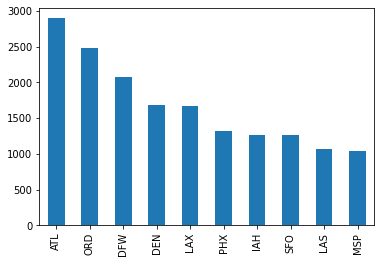

In [52]:
df_flights.ORIGIN_AIRPORT.value_counts()[0:10].plot(kind = 'bar')

<AxesSubplot:>

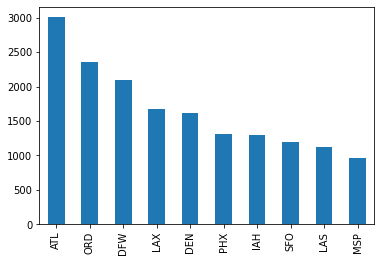

In [53]:
df_flights.DESTINATION_AIRPORT.value_counts()[0:10].plot(kind = 'bar')

<AxesSubplot:xlabel='CANCELLED', ylabel='count'>

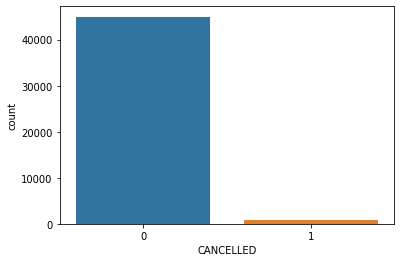

In [55]:
sns.countplot(data = df_flights, x = 'CANCELLED')

In [56]:
df_flights.CANCELLED.value_counts(normalize = True)

0    0.984008
1    0.015992
Name: CANCELLED, dtype: float64

<AxesSubplot:xlabel='CANCELLATION_REASON', ylabel='count'>

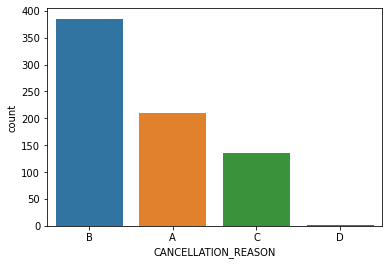

In [57]:
sns.countplot(data = df_flights, x = 'CANCELLATION_REASON')

In [54]:
df_flights.columns

Index(['MONTH', 'DAY', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DISTANCE', 'ARRIVAL_DELAY', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY'],
      dtype='object')

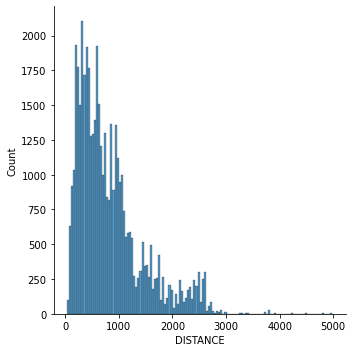

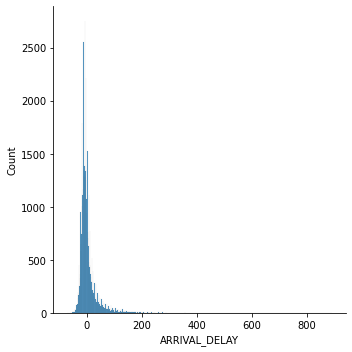

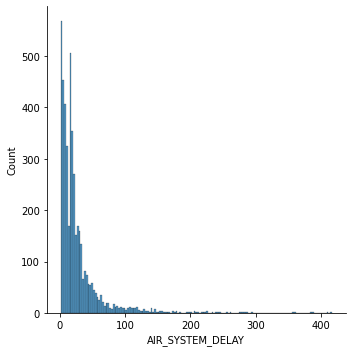

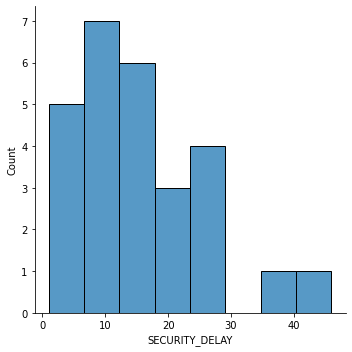

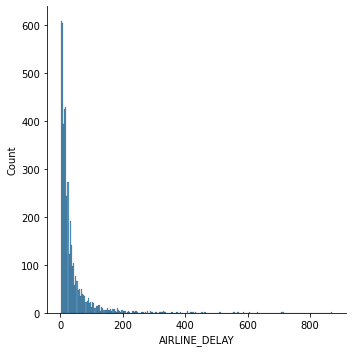

In [63]:
for col in ['DISTANCE', 'ARRIVAL_DELAY','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY']:
    sns.displot(df_flights.loc[df_flights[col] != 0, col], kde = False)

In [64]:
df_flights.drop('ARRIVAL_DELAY', axis = 1, inplace = True)

### Univariate analysis

### Bivariate analysis

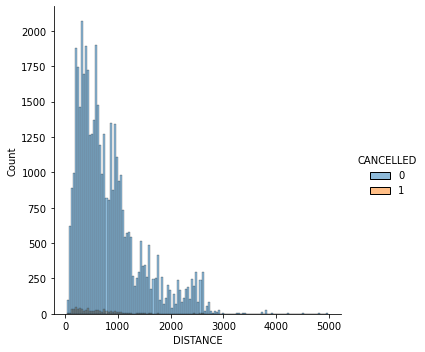

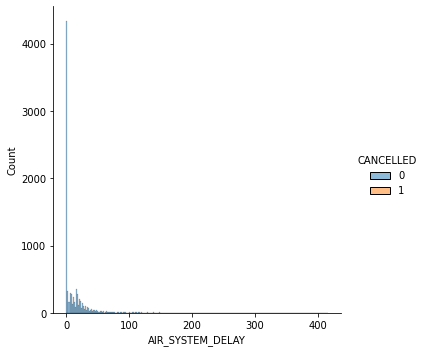

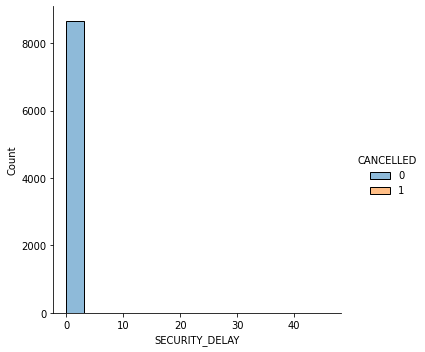

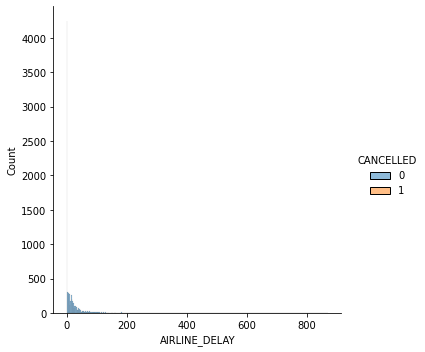

In [79]:
for col in ['DISTANCE','AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY']:
    sns.displot(data = df_flights, x = col, hue = 'CANCELLED')

In [82]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45710 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                45710 non-null  int64  
 1   DAY                  45710 non-null  int64  
 2   AIRLINE              45710 non-null  object 
 3   ORIGIN_AIRPORT       45710 non-null  object 
 4   DESTINATION_AIRPORT  45710 non-null  object 
 5   DISTANCE             45710 non-null  int64  
 6   CANCELLED            45710 non-null  int64  
 7   CANCELLATION_REASON  731 non-null    object 
 8   AIR_SYSTEM_DELAY     8677 non-null   float64
 9   SECURITY_DELAY       8677 non-null   float64
 10  AIRLINE_DELAY        8677 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 5.2+ MB


In [84]:
df_flights['CANCELLATION_REASON'].unique() ## N_C

array([nan, 'B', 'A', 'C', 'D'], dtype=object)

In [88]:
df_flights['CANCELLATION_REASON'].fillna('N_C', inplace = True)

In [92]:
df_flights[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY']] = df_flights[['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY']].fillna(0)

In [113]:
df_flights['MONTH'] = df_flights['MONTH'].apply(int)

In [114]:
df_flights['DAY'] = df_flights['DAY'].apply(int)

In [116]:
df_flights['CANCELLED'] = df_flights['CANCELLED'].apply(int)

In [118]:
df_flights['DISTANCE'] = df_flights['DISTANCE'].apply(int)

In [119]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45710 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MONTH                45710 non-null  int64  
 1   DAY                  45710 non-null  int64  
 2   AIRLINE              45710 non-null  object 
 3   ORIGIN_AIRPORT       45710 non-null  object 
 4   DESTINATION_AIRPORT  45710 non-null  object 
 5   DISTANCE             45710 non-null  int64  
 6   CANCELLED            45710 non-null  int64  
 7   CANCELLATION_REASON  45710 non-null  object 
 8   AIR_SYSTEM_DELAY     45710 non-null  float64
 9   SECURITY_DELAY       45710 non-null  float64
 10  AIRLINE_DELAY        45710 non-null  float64
dtypes: float64(3), int64(4), object(4)
memory usage: 5.2+ MB


#### Model building and evaluation

In [102]:
from sklearn.preprocessing import StandardScaler , RobustScaler , MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

In [106]:
df_flights.columns

Index(['MONTH', 'DAY', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DISTANCE', 'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY'],
      dtype='object')

In [124]:
df_flights.drop('CANCELLATION_REASON', axis = 1, inplace = True)

In [125]:
Encoder = ColumnTransformer(  
    transformers=[("Encoder_oh",OneHotEncoder(sparse=False,drop="first"),['AIRLINE']),
                  ("Encoder_bin", BinaryEncoder(),['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'])
                 ] , remainder="passthrough")

In [126]:
X = df_flights.drop('CANCELLED', axis = 1)
y = df_flights['CANCELLED']

In [127]:
models = list()
models.append(("CART" , DecisionTreeClassifier(max_depth=6 , max_leaf_nodes=10 , max_features=5)))
models.append(("MNB" , MultinomialNB()))
models.append(("GNB" , GaussianNB()))
models.append(("LR" , LogisticRegression()))
models.append(("XG" , XGBClassifier(n_estimators=10)))
models.append(("RF" , RandomForestClassifier(n_estimators=20)))

In [128]:
steps = list()
steps.append(("Encoder",Encoder))
steps.append(("Scaler" , MinMaxScaler()))
steps.append(models[0])
pipeline = Pipeline(steps)
scores = cross_validate(pipeline , X , y , cv = 5  , scoring="f1" , return_train_score=True)
print(model[0])
print("train_f1", scores["train_score"].mean())
print("test_f1" , scores["test_score"].mean())
print("-" * 25)

RF
train_f1 0.0006825938566552901
test_f1 0.0
-------------------------


In [131]:
for model in models:
    steps = list()
    steps.append(("Encoder",Encoder))
    steps.append(("Scaler" , MinMaxScaler()))
    steps.append(model)
    pipeline = Pipeline(steps)
    scores = cross_validate(pipeline , X , y , cv = 5  , scoring="f1" , return_train_score=True)
    print(model[0])
    print("train_f1", scores["train_score"].mean())
    print("test_f1" , scores["test_score"].mean())
    print("-" * 25)

CART
train_f1 0.0013651877133105802
test_f1 0.0
-------------------------
MNB
train_f1 0.0
test_f1 0.0
-------------------------
GNB
train_f1 0.03936082905732827
test_f1 0.03941434592002639
-------------------------
LR
train_f1 0.0
test_f1 0.0
-------------------------
XG
train_f1 0.034863501939534906
test_f1 0.008089969163794666
-------------------------
RF
train_f1 0.9303769569332319
test_f1 0.02540386310418131
-------------------------


In [139]:
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
model = BalancedRandomForestClassifier()
steps = list()
steps.append(("Encoder",Encoder))
steps.append(("Scaler" , MinMaxScaler()))
steps.append(('BRFC', model))
pipeline = Pipeline(steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.2, random_state = 1, stratify = y)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Encoder_oh',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['AIRLINE']),
                                                 ('Encoder_bin',
                                                  BinaryEncoder(),
                                                  ['ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT'])])),
                ('Scaler', MinMaxScaler()),
                ('BRFC', BalancedRandomForestClassifier())])

In [140]:
f1_score(pipeline.predict(X_train), y_train)

0.09320140440472391

In [141]:
confusion_matrix(pipeline.predict(X_train), y_train)

array([[6155,    0],
       [2841,  146]])

In [142]:
f1_score(pipeline.predict(X_test), y_test)

0.06380027739251039

In [144]:
f1_score(pipeline.predict(X_train), y_train)

0.1551155115511551

In [145]:
f1_score(pipeline.predict(X_test), y_test)

0.07526580861779521

In [147]:
model = BalancedBaggingClassifier()

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state = 1, stratify = y)
Over = SMOTE(sampling_strategy=0.25)
Under = RandomUnderSampler()
steps = list()
steps.append(("Encoder",Encoder))
steps.append(("Over", Over))
steps.append(("Under", Under))
steps.append(("Scaler" , StandardScaler()))
steps.append(('BBC', model))
pipeline = Pipeline(steps)

In [152]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Encoder_oh',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['AIRLINE']),
                                                 ('Encoder_bin',
                                                  BinaryEncoder(),
                                                  ['ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT'])])),
                ('Over', SMOTE(sampling_strategy=0.25)),
                ('Under', RandomUnderSampler()), ('Scaler', StandardScaler()),
                ('BBC', BalancedBaggingClassifier())])

In [153]:
f1_score(pipeline.predict(X_train), y_train)

0.7272727272727272

In [154]:
f1_score(pipeline.predict(X_test), y_test)

0.04230317273795534

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.3, random_state = 1, stratify = y)
Over = SMOTE(sampling_strategy=0.25)
Under = RandomUnderSampler()
steps = list()
steps.append(("Encoder",Encoder))
steps.append(("Over", Over))
steps.append(("Under", Under))
steps.append(("Scaler" , StandardScaler()))
steps.append(("XG" , XGBClassifier()))
pipeline = Pipeline(steps)

In [157]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Encoder_oh',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['AIRLINE']),
                                                 ('Encoder_bin',
                                                  BinaryEncoder(),
                                                  ['ORIGIN_AIRPORT',
                                                   'DESTINATION_AIRPORT'])])),
                ('Over', SMOTE(sampling_strategy=0.25)),
                ('Under', RandomUnderSampler()), ('Scaler', StandardScaler()),
                ('XG',
                 XGBClassifier(base_...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constra

In [158]:
f1_score(pipeline.predict(X_train), y_train)

0.709030100334448

In [159]:
f1_score(pipeline.predict(X_test), y_test)

0.12761904761904763